In [6]:
import mat73
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, pearsonr, spearmanr

# from importlib import reload
# import feature_extraction
# reload(feature_extraction)
from plotting import plot_series, get_eeg_pearson_correlation_series, get_pearson_correlation_series
from biomarkers import BioMarkers, EEG, EMG, EOG, ALL_MARKERS
from feature_extraction import concatenate_features, get_frequency_idx, get_spectral_power, get_feature_by_name, Feature, EEG_BANDS, FEATURE_TO_FUNC
from data_utils import load_data_from_dir, get_features_in_all_blocks, get_behavior_labels, transform_to_marker_to_all_block

# Train machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GroupKFold,GridSearchCV,cross_val_score,cross_validate

# from biosppy.signals import eeg
# from biosppy import plotting

In [2]:
DIR_NAME = "../1004_CleanData"

all_data = load_data_from_dir(DIR_NAME)
marker_to_block = transform_to_marker_to_all_block(all_data)

Complete loading 10 markers
Loaded audio_hvla block
Complete loading 10 markers
Loaded breath_hvha block
Complete loading 10 markers
Loaded breath_nvha block
Complete loading 10 markers
Loaded audio_nvla block
Complete loading 10 markers
Loaded breath_nvla block
Complete loading 10 markers
Loaded mind wandering block
Complete loading 10 markers
Loaded audio_nvha block
Complete loading 10 markers
Loaded audio_hvha block
Complete loading 10 markers
Loaded meditation block
Complete loading 10 markers
Loaded breath_hvla block


In [3]:
valence_label = get_behavior_labels(all_data, 'valence')
arousal_label = get_behavior_labels(all_data, 'arousal')
attention_label = get_behavior_labels(all_data, 'attention')

All labels shape: (130,)
All labels shape: (130,)
All labels shape: (130,)


The mean -0.13246630793807096 over feature DELTA
The mean -0.14124609524659418 over feature THETA
The mean -0.16096300914919787 over feature ALPHA
The mean -0.11725935443380513 over feature BETA1
The mean -0.12177006164857142 over feature BETA2
The mean -0.18036956748176616 over feature GAMMA


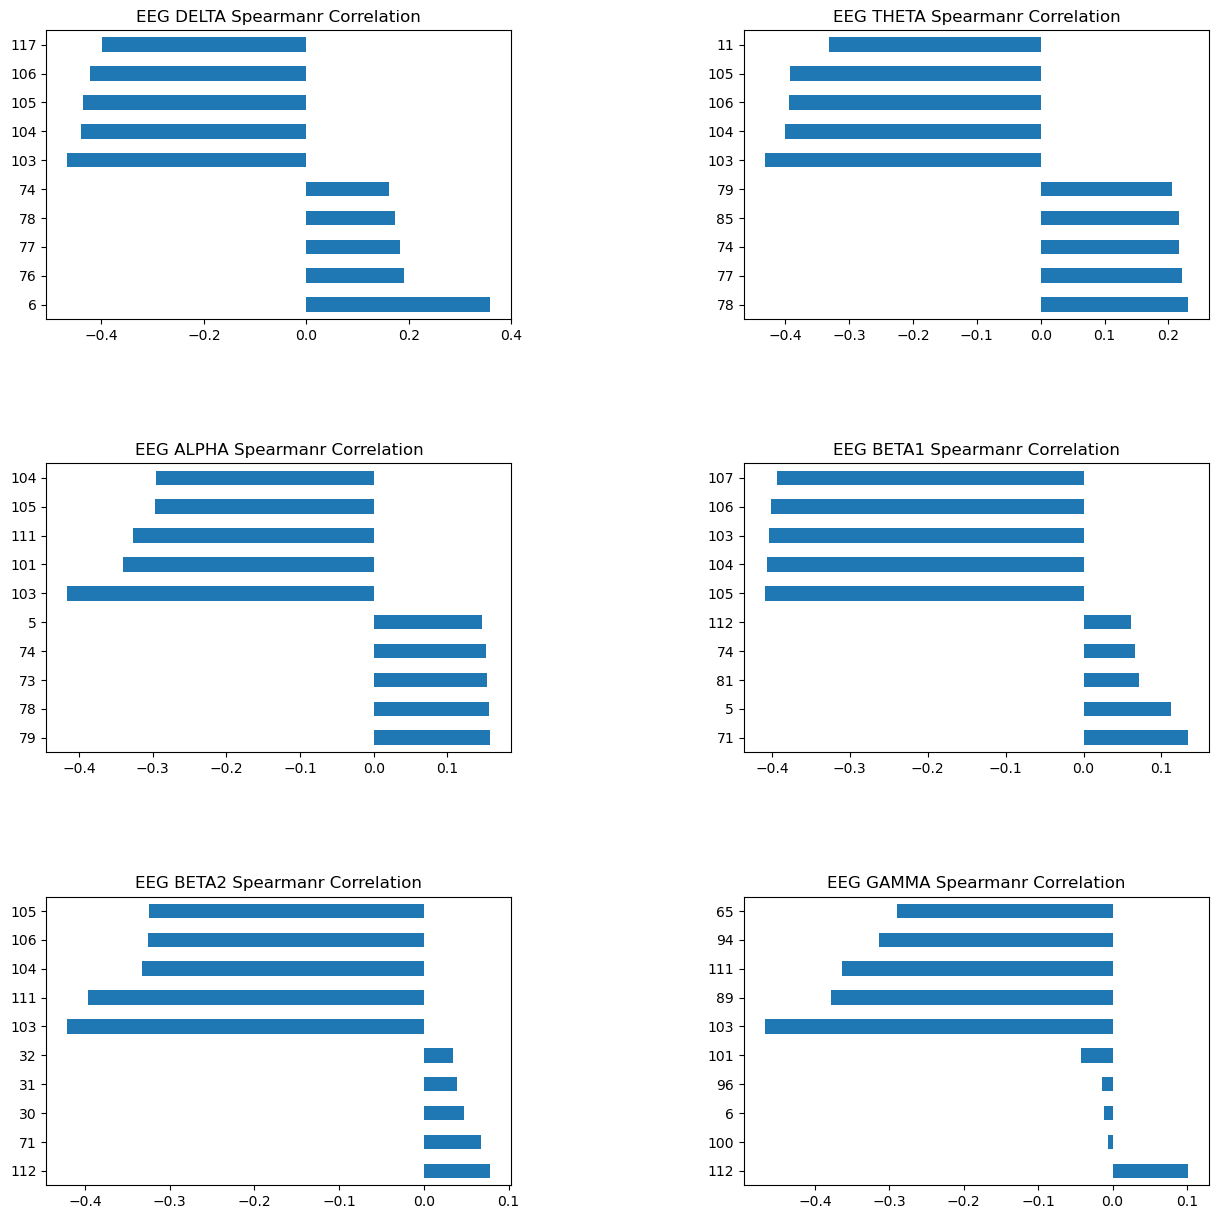

In [14]:
# ser_list = get_pearson_correlation_series(marker_to_block, {'BP', 'ECG', 'EGG', 'GSR', 'Resp', 'TREV'}, attention_label)
# ser_list = ser_list + get_pearson_correlation_series(marker_to_block, {'EMG', 'EOG'}, attention_label, 2)

ser_list = get_eeg_pearson_correlation(marker_to_block['EEG'], arousal_label)

#define number of rows and columns for subplots
nrow=3
ncol=2
plot_series(nrow,ncol,ser_list)

In [3]:
all_features = get_features_in_all_blocks(all_blocks=all_data)

print(f"All feature shape {all_features.shape}")

BP feature shape (13, 11)
ECG feature shape (13, 11)
EEG feature shape (13, 1408)
EGG feature shape (13, 11)
EMG feature shape (13, 22)
EOG feature shape (13, 22)
GSR feature shape (13, 11)
Resp feature shape (13, 11)
TREV feature shape (13, 11)
EEG spetral features shape (13, 768)
audio_hvla block has features: (13, 2286)...
BP feature shape (13, 11)
ECG feature shape (13, 11)
EEG feature shape (13, 1408)
EGG feature shape (13, 11)
EMG feature shape (13, 22)
EOG feature shape (13, 22)
GSR feature shape (13, 11)
Resp feature shape (13, 11)
TREV feature shape (13, 11)
EEG spetral features shape (13, 768)
breath_hvha block has features: (13, 2286)...
BP feature shape (13, 11)
ECG feature shape (13, 11)
EEG feature shape (13, 1408)
EGG feature shape (13, 11)
EMG feature shape (13, 22)
EOG feature shape (13, 22)
GSR feature shape (13, 11)
Resp feature shape (13, 11)
TREV feature shape (13, 11)
EEG spetral features shape (13, 768)
breath_nvha block has features: (13, 2286)...
BP feature sha

In [45]:
def normalize_label(all_labels, low, high):
    y_transformed = []
    c0, c1, c2 = 0, 0, 0
    for label in all_labels:
        if label < low:
            y_transformed.append(0)
            c0+=1
        elif label >= low and label < high: 
            y_transformed.append(1)
            c1+=1
        else:
            y_transformed.append(2)
            c2+=1

    print(f'0 label: {c0}, 1 label: {c1}, 2 label {c2}')
    return y_transformed



In [21]:
#convert y values to categorical values
y_transformed =[]
if label_name == 'valence':
    y_transformed = normalize_label(all_labels, 0.6, 0.8)
elif label_name == 'arousal':
    y_transformed = normalize_label(all_labels, 0.4, 0.7)
else:
    y_transformed = normalize_label(all_labels, 0.82, 0.92)

0 label: 41, 1 label: 49, 2 label 40


In [22]:
groups_list=[[i] for i, j in enumerate(all_labels)]
group_array=np.hstack(groups_list)

print(group_array)
print(all_features.shape, all_labels.shape, group_array.shape)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129]
(130, 2286) (130,) (130,)


In [23]:
clf=LogisticRegression(max_iter=200)
gkf=GroupKFold(n_splits=5)
param_grid = {'classifier__C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}
pipe=Pipeline([('scaler',StandardScaler()),('classifier',clf)])
gscv=GridSearchCV(pipe,param_grid,cv=gkf,n_jobs=16)
gscv.fit(all_features,y_transformed,groups=group_array)

GridSearchCV(cv=GroupKFold(n_splits=5),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(max_iter=200))]),
             n_jobs=16,
             param_grid={'classifier__C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                           10, 100]})

In [24]:
best_model = gscv.best_estimator_
print(f'best model: {best_model}')
print(gscv.best_score_)

best model: Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression(C=0.001, max_iter=200))])
0.5


In [25]:
# BP feature shape (13, 11)
# ECG feature shape (13, 11) 22
# EEG feature shape (13, 1408) 1430
# EGG feature shape (13, 11) 1441
# EMG feature shape (13, 22) 1463
# EOG feature shape (13, 22) 1485
# GSR feature shape (13, 11) 1496
# Resp feature shape (13, 11) 1507
# TREV feature shape (13, 11) 1518
# features = (mean(data),std(data),ptp(data),var(data),minim(data),maxim(data),
#                           mean_square(data),rms(data),abs_diffs_signal(data),
#                           skewness(data),kurtosis(data))
# EEG spetral features shape (13, 768) 2286-768=

STATS_NAME = ['mean', 'std', 'ptp', 'var', 'minim', 'maxim', 'mean_square', 'rms', 'abs_diffs_signal', 'skewness', 'kurtosis']
EEG_BANDS = ["Delta","Theta","Alpha","Beta1","Beta2","Gamma"]
def get_stats_name(i) -> str:
    pos = i%11
    return STATS_NAME[pos]

def get_feature_names(features):
    index=[]
    for i, j in enumerate(features):
        stat_name = get_stats_name(i)
        if i < 11:
            name = 'BP'
        elif i < 22:
            name = 'ECG'
        elif i < 1430:
            channel = int((i-22)/11)+1
            name = f'EEG {channel}'
        elif i < 1441:
            name = 'EGG'
        elif i < 1463:
            channel = int((i-1441)/11)+1
            name = f'EMG {channel}'   
        elif i < 1485:
            channel = int((i-1463)/11)+1
            name = f'EOG {channel}'
        elif i < 1496:
            name = 'GSR'
        elif i < 1507:
            name = 'Resp'
        elif i < 1518:
            name = 'TREV'
        else:    
            channel = int((i-1518)/6)+1
            name = f'EEG {channel}'
            stat_name = EEG_BANDS[(i-1518)%6]
            
        index.append(f'{name} {stat_name}')
    return index

<AxesSubplot:title={'center':'attention Feature Importance'}>

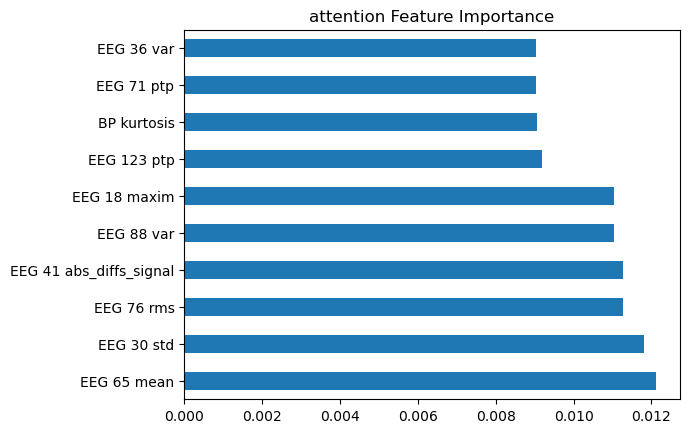

/Users/tpan/miniconda3/envs/MM/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/tpan/miniconda3/envs/MM/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/tpan/miniconda3/envs/MM/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/tpan/miniconda3/envs/MM/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

In [26]:
# assume bigger coefficents has more contribution to the model
# but have to be sure that the features has THE SAME SCALE otherwise this assumption is not correct. 
importance = best_model['classifier'].coef_[0] 
    
feat_importances = pd.Series(importance, index=get_feature_names(importance))
feat_importances.nlargest(10).plot(kind='barh',title = f'{label_name} Feature Importance')

<AxesSubplot:title={'center':'Feature Importance'}>

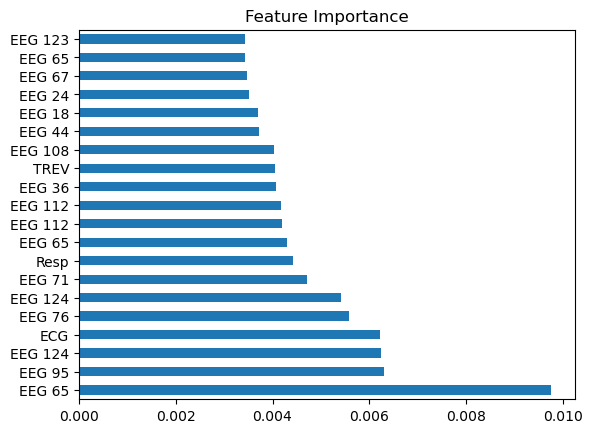

In [49]:
# using Randoom forest (not suitable as the data is too small and the model will overfit easily)
# from sklearn.ensemble import RandomForestClassifier
# import matplotlib

# clf = RandomForestClassifier()
# clf = clf.fit(all_features,y_transformed)
# clf.feature_importances_  
# feat_importances = pd.Series(clf.feature_importances_, index=get_feature_names(clf.feature_importances_))
# feat_importances.nlargest(20).plot(kind='barh',title = 'Feature Importance')